# Boletín 4: Redes Neuronales

## Importamos las librerías a utilizar

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt


In [11]:
%matplotlib inline
matplotlib.style.use('ggplot')

# Para evitar warnings en algunas gráficas
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})


## Definimos variables globales

In [12]:
# Establecemos esta semilla para eliminar aleatoriedad y obtener siempre los mismos resultados
SEED_VALUE = 1


## Ejercicio 1

### Apartado a

En primer lugar, debemos definir los funciones que usaremos para calcular los valores que se nos piden a partir de nuestra red:

In [13]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# This is the forward propagation function
def forward_prop(model, a1):
    # Load parameters from model
    W1, b1, W2, b2,  = model['W1'], model['b1'], model['W2'], model['b2']

    # Do the first linear step
    z2 = W1.dot(a1) + b1
    # Put it through the first activation function
    a2 = sigmoid(z2)

    # Second linear step
    z3 = W2.dot(a2) + b2
    # For the third linear activation function we use the identity function
    a3 = z3

    # Store all results in these values
    cache = {'a1': a1, 'z2': z2, 'a2': a2, 'a3': a3, 'z3': z3}
    
    return cache


Ahora definimos los valores para los pesos y los bias de cada una de las capas, así como el valor de entrada de nuestra red:

In [14]:
W1 = np.array([
    [-2., 1.],
    [1., -1.],
    [3., -1.]
])

b1 = np.array([
    [0.],
    [-1.],
    [1.]
])

W2 = np.array([
    [2., 3., 1.]
])

b2 = np.array([[0.]])

a1 = np.array([
    [1.],
    [1.]
])


Por último ejecutamos para obtener los valores que buscamos:

In [15]:
model = {
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2
}

results = forward_prop(model, a1)

for key in results:
    print(f"{key} = {results[key]}")


a1 = [[1.]
 [1.]]
z2 = [[-1.]
 [-1.]
 [ 3.]]
a2 = [[0.26894142]
 [0.26894142]
 [0.95257413]]
a3 = [[2.29728123]]
z3 = [[2.29728123]]


### Apartado b

Ahora, mediante el algoritmo de retro-propagación, calcularemos el valor de delta para todas las neuronas. Para esto lo primero es definir la función que nos permitirá calcular la derivada de la función sigmoide:

In [16]:
def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))
    

Ahora, calcularemos los valores de delta para todas las neuronas. Cabe destacar que como la función de activación de la neurona de salida es la función identidad, su derivada será igual a 1.

In [18]:
def get_deltas(model, results, y):
    # Load parameters from model
    W2  = model['W2']

    # Load results from previous step
    z2, a3  = results['z2'], results['a3']

    # Get delta for the output layer (layer 3)
    delta3 = -(y - a3)

    # Get deltas for the second layer
    delta2 = ((W2.T).dot(delta3)) * sigmoid_der(z2)
    
    # Store all results in these values
    cache = {'delta3':delta3, 'delta2': delta2}

    return cache

delta_results = get_deltas(model, results, y=1)

for key in delta_results:
    print(f"{key} = {delta_results[key]}")


delta3 = [[1.29728123]]
delta2 = [[0.51012194]
 [0.76518291]
 [0.05860683]]


### Apartado c

Ahora por último utilizaremos el algoritmo de retro-propagación del error para determinar los valores finales de cada peso y de cada bias asumiendo unos valores de `lambda` igual a 1 y una tasa de aprendizaje `alpha` igual a 0,5; tras la primera iteración del algoritmo.

Esto lo haremos en la siguiente celda de código:

In [20]:
def update_weights(model, results, delta_results, lamda=1, alpha=0.5):
    # Load parameters from model
    W1, b1, W2, b2,  = model['W1'], model['b1'], model['W2'], model['b2']

    # Load results from previous step
    a1, a2 = results['a1'], results['a2']

    # Load deltas from previous step
    delta2, delta3 = delta_results['delta2'], delta_results['delta3']

    # Update first layer
    W1 = W1 - alpha * (delta2.dot(a1.T) + lamda * W1)
    b1 = b1 - alpha * delta2

    # Update second layer
    W2 = W2 - alpha * (delta3.dot(a2.T) + lamda * W2)
    b2 = b2 - alpha * delta3

    cache = {
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2
    }

    return cache

updated_model = update_weights(model, results, delta_results, 1, 0.5)

for key in updated_model:
    print(f"{key} = {updated_model[key]}")


W1 = [[-1.25506097  0.24493903]
 [ 0.11740854 -0.88259146]
 [ 1.47069658 -0.52930342]]
b1 = [[-0.25506097]
 [-1.38259146]
 [ 0.97069658]]
W2 = [[ 0.82555367  1.32555367 -0.11787827]]
b2 = [[-0.64864062]]


## Ejercicio 2

Ahora trabajaremos con el conjunto de datos [Blood Transfusion Service Center](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center).

### Apartado 0

En primer lugar, leemos los datos del fichero de entrada:

In [21]:
df_blood_transfusion = pd.read_csv(
    'data/bloodTransfusion.data', 
    delimiter=',',
    skiprows=1,
    header=None,
    names = ["Recency", "Frequency", "Monetary", "Time", "IsMarchDonor"]
)


### Apartado a

**Una de las clases que implementa el Perceptrón multicapa (MLP) en problemas de clasificación en `scikit‐learn` es `sklearn.neural_network.MLPClassifier`. Revisa los parámetros y métodos que tiene.**

Se revisa la documentación de la clase `sklearn.neural_network.MLPClassifier` para entender los parámetros que tiene, qué hace cada uno, y los métodos que tiene, y cuál es la función de cada uno.

### Apartado b

**Divide los datos en entrenamiento (80%) y test (20%).**

Dividimos los datos en entrenamiento (80%) y test (20%) mediante este comando:

In [22]:
df_blood_transfusion_train, df_blood_transfusion_test = train_test_split(
    df_blood_transfusion,
    test_size=0.2,
    random_state=SEED_VALUE
)


Comprobamos el tamaño del conjunto de entrenamiento:

In [23]:
df_blood_transfusion_train.shape


(598, 5)

Y el tamaño del conjunto de test:

In [24]:
df_blood_transfusion_test.shape


(150, 5)

### Apartado c

**Realiza la experimentación con MLPClassifier usando los valores por defecto de los parámetros, excepto para activation='tanh' y solver='lbfgs', y max_iter=2000.**

En primer lugar, para llevar a cabo la experimentación con *MLPClassifier* es necesario que separemos las variables predictoras y dependientes:

In [25]:
df_blood_transfusion_train_X = df_blood_transfusion_train.loc[:, [
    'Recency', 'Frequency', 'Monetary', 'Time']].astype(float)
df_blood_transfusion_train_Y = df_blood_transfusion_train.loc[:, 'IsMarchDonor']

df_blood_transfusion_test_X = df_blood_transfusion_test.loc[:, [
    'Recency', 'Frequency', 'Monetary', 'Time']].astype(float)
df_blood_transfusion_test_Y = df_blood_transfusion_test.loc[:, 'IsMarchDonor']


Ahora llevaremos a cabo la estandarización de los datos, además, al ser un problema de clasificación **NO** es necesario que estandaricemos la variable dependiente:

In [26]:
scaler = StandardScaler()
scaler.fit(df_blood_transfusion_train_X)
df_blood_transfusion_train_X_scaled = scaler.transform(df_blood_transfusion_train_X)
df_blood_transfusion_test_X_scaled = scaler.transform(df_blood_transfusion_test_X)


Ahora que ya hemos acabado con el pre-procesado de los datos, podemos empezar con la experimentación. En primer lugar definimos los hiperparámetros con los que trabajaremos:

In [27]:
n_hidden_layers_array = range(1, 4, 1)
n_neurons_per_layer_array = range(1, 26, 1)
alpha_exp_array = range(-4, 2, 1)

# Generamos diferentes valores para el hiper-parametro del numero de capas
hidden_layer_sizes = []
for n_hidden_layers in n_hidden_layers_array:
    for n_neurons_per_layer in n_neurons_per_layer_array:
        hidden_layer_sizes.append((n_neurons_per_layer, ) * n_hidden_layers)

# Generamos diferentes valores para el hiper-parámetro alpha
alpha = []
for value in alpha_exp_array:
    alpha.append(10 ** value)
    alpha.append((10 ** value) * 5)

hyperparameters = {'hidden_layer_sizes': hidden_layer_sizes, 'alpha': alpha}


Ahora ejecutamos el entrenamiento:

In [28]:
neural_network = MLPClassifier(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)
modelCV = GridSearchCV(neural_network,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy',
                       return_train_score=True,
                       n_jobs=-1)

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV.fit(df_blood_transfusion_train_X_scaled, df_blood_transfusion_train_Y)


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', max_iter=2000,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                   0.1, 0.5, 1, 5, 10, 50],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,),
                                                (11,), (12,), (13,), (14,),
                                                (15,), (16,), (17,), (18,),
                                                (19,), (20,), (21,), (22,),
                                                (23,), (24,), (25,), (1, 1),
                                                (2, 2), (3, 3), (4, 4), (5, 5), ...]},
             return_train_score=True, scoring='accuracy')

Ahora podemos consultar los resultados obtenidos, mostrando un ranking con los mejores resultados ordenados de mejor a peor:

In [29]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results['mean_test_score'] = 1 - cv_results['mean_test_score']

cv_results.loc[:, [
    'param_hidden_layer_sizes', 
    'param_alpha',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


param_hidden_layer_sizes param_alpha  mean_test_score  std_test_score  \
229                     (5,)       0.005         0.194048        0.030102   
528                     (4,)         0.5         0.195756        0.039330   
453                     (4,)         0.1         0.195770        0.040780   
304                     (5,)        0.01         0.197381        0.028210   
653                (4, 4, 4)           1         0.197395        0.034601   
..                       ...         ...              ...             ...   
69              (20, 20, 20)      0.0001         0.309384        0.006189   
599             (25, 25, 25)         0.5         0.311008        0.025211   
289             (15, 15, 15)       0.005         0.311036        0.020001   
592             (18, 18, 18)         0.5         0.312717        0.016437   
437             (13, 13, 13)        0.05         0.314370        0.006013   

     rank_test_score  
229                1  
528                2  
453                3  
304                4  
653                5  
..               ...  
69               896  
599              897  
289              898  
592              899  
437              900  

[900 rows x 5 columns]

**Muestra las gráficas del error de entrenamiento con validación cruzada (5‐CV) frente al valor de los hiper‐parámetros, y justifica la elección de los valores más apropiados. Para cada combinación de valor del número de capas ocultas y parámetro de regularización se debe generar una gráfica donde se represente en el eje horizontal el número de neuronas en la capa oculta.**

Para esto lo primero será procesar el DataFrame con los resultados de haber ejecutado la búsqueda de los mejores hiper-parámetros para obtener **el número de capas ocultas** y el **número de neuronas por capa** para cada una de las filas de este DataFrame a partir de la columna `param_hidden_layer_sizes`:

In [30]:
# Get number of layers for every row in the results DataFrame
hidden_layer_sizes = []
for tuple in cv_results['param_hidden_layer_sizes']:
    hidden_layer_sizes.append(len(tuple))
cv_results['n_hidden_layers'] = pd.Series(hidden_layer_sizes)

# Get number of neurons per layer for every row in the results DataFrame
neurons_per_layer = []
for tuple in cv_results['param_hidden_layer_sizes']:
    neurons_per_layer.append(tuple[0])
cv_results['n_neurons_per_layer'] = pd.Series(neurons_per_layer)


Mostramos las gráficas con los resultados del entrenamiento:

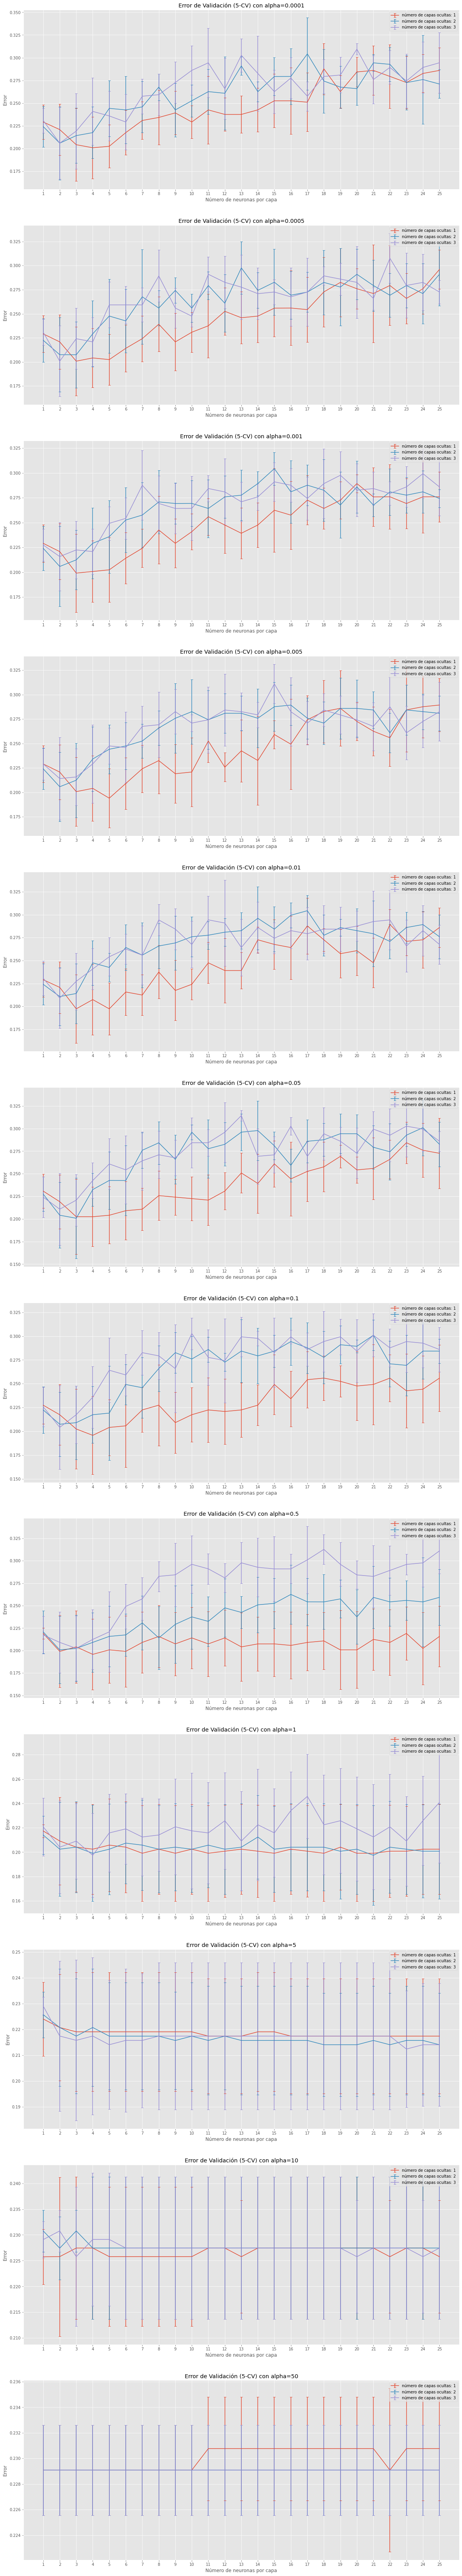

In [32]:
# Set up the graph
fig, axes = plt.subplots(figsize=(20, 120), nrows=len(hyperparameters['alpha']))

# Set the counter to graph on the correct axes
counter = 0

# Graph for every combination of number of layers and value of alpha
for alpha in hyperparameters['alpha']:
    cv_results_one_layer = cv_results[cv_results['n_hidden_layers'] == 1]
    cv_results_one_layer = cv_results_one_layer[cv_results_one_layer['param_alpha'] == alpha]

    cv_results_two_layer = cv_results[cv_results['n_hidden_layers'] == 2]
    cv_results_two_layer = cv_results_two_layer[cv_results_two_layer['param_alpha'] == alpha]

    cv_results_three_layer = cv_results[cv_results['n_hidden_layers'] == 3]
    cv_results_three_layer = cv_results_three_layer[cv_results_three_layer['param_alpha'] == alpha]

    # Graph
    axes[counter].set_title(f"Error de Validación (5-CV) con alpha={alpha}")
    axes[counter].set_xlabel("Número de neuronas por capa")
    axes[counter].set_xticks(n_neurons_per_layer_array)
    axes[counter].set_ylabel("Error")
    axes[counter].errorbar(
        cv_results_one_layer['n_neurons_per_layer'],
        cv_results_one_layer['mean_test_score'],
        cv_results_one_layer['std_test_score'],
        label=f'número de capas ocultas: {1}',
        capsize = 3)
    axes[counter].errorbar(
        cv_results_two_layer['n_neurons_per_layer'],
        cv_results_two_layer['mean_test_score'],
        cv_results_two_layer['std_test_score'],
        label=f'número de capas ocultas: {2}',
        capsize = 3)
    axes[counter].errorbar(
        cv_results_three_layer['n_neurons_per_layer'],
        cv_results_three_layer['mean_test_score'],
        cv_results_three_layer['std_test_score'],
        label=f'número de capas ocultas: {3}',
        capsize = 3)
    axes[counter].legend(loc="upper right")

    # Update counter
    counter += 1


Como se puede ver para los valores relativamente altos del hiper-parámetro `alpha` (valores iguales o superiores a 1) la red neuronal, independientemente del **número de capas ocultas** o del **número de neuronas por cada una de las capas ocultas**, no está aprendiendo correctamente, ya que el error se mantiene más o menos igual a pesar del cambio en el valor de los hiper-parámetros.

Por otra parte, para valores de `alpha` menores a 1, sí que se puede ver como la red disminuye el error de validación cruzada cuando aumentan las neuronas en las capas ocultas, obteniendo los mejores valores entorno entre 3 y 6 neuronas en cada una de las capas ocultas para todas las combinaciones de los hiper-parámetros. Al seguir aumentando el número de neuronas por capa a partir de 6, el error de validación empieza a aumentar poco. Cabe destacar que no se probó a entrenar la red con más de 25 neuronas por capa debido a que los tiempos de entrenamiento se volverían cada vez más largos con este aumento en la complejidad de la red; y además no tiene mucho sentido utilizar un número de neuronas tan elevado para entrenar una red que sólo tiene 4 neuronas en la capa de entrada. Esto se puede ver en las gráficas superiores, en las que se comprueba como el error va aumentando a medida que aumenta el número de neuronas por capa.

Por lo tanto, lo mejor será quedarse con la red, con menos de 8 neuronas por capa, que mejor error de validación consiga.

El **menor error de validación cruzada**, **su desviación estándar** y el **hiper-parámetro para el que se consigue** es el siguiente:

In [33]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]

cv_results_best.loc[:, [
    'param_hidden_layer_sizes', 
    'param_alpha',
    'n_hidden_layers',
    'n_neurons_per_layer',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='n_hidden_layers', 
    ascending=False
).head()


param_hidden_layer_sizes param_alpha  n_hidden_layers  \
229                     (5,)       0.005                1   

     n_neurons_per_layer  mean_test_score  std_test_score  rank_test_score  
229                    5         0.194048        0.030102                1

**Muestra la gráfica del error de test frente al valor de los hiper‐parámetros (siguiendo el mismo esquema que en el apartado anterior), y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test.**

En primer lugar, debemos calcular el error de test frente a los valores de los hiper-parámetros:

In [34]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_blood_transfusion_train_Y) + [0] * len(df_blood_transfusion_test_Y)
ps = PredefinedSplit(test_fold = split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_blood_transfusion_all_X_scaled = np.vstack(
    [df_blood_transfusion_train_X_scaled, df_blood_transfusion_test_X_scaled])
df_blood_transfusion_all_Y = pd.concat(
    [df_blood_transfusion_train_Y, df_blood_transfusion_test_Y])

neural_network = MLPClassifier(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)
modelCV = GridSearchCV(neural_network,
                       hyperparameters,
                       cv=ps,
                       scoring='accuracy',
                       return_train_score=True,
                       n_jobs=-1)

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV.fit(df_blood_transfusion_all_X_scaled, df_blood_transfusion_all_Y)


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPClassifier(activation='tanh', max_iter=2000,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                   0.1, 0.5, 1, 5, 10, 50],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,),
                                                (11,), (12,), (13,), (14,),
                                                (15,), (16,), (17,), (18,),
                                                (19,), (20,), (21,), (22,),
                                                (23,), (24,), (25,), (1, 1),
                                                (2, 2), (3, 3), (4, 4), (5, 5), ...]},
             return_train_score=True, scoring='accuracy')

Guardamos estos resultados y mostramos por pantalla:

In [37]:
test_results = pd.DataFrame(modelCV.cv_results_)
test_results['mean_test_score'] = 1 - test_results['mean_test_score']

test_results.loc[:, [
    'param_hidden_layer_sizes', 
    'param_alpha',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


param_hidden_layer_sizes param_alpha  mean_test_score  std_test_score  \
619                    (20,)           1         0.193333             0.0   
501                (2, 2, 2)         0.1         0.193333             0.0   
352                (3, 3, 3)        0.01         0.193333             0.0   
277                (3, 3, 3)       0.005         0.193333             0.0   
624                    (25,)           1         0.193333             0.0   
..                       ...         ...              ...             ...   
512             (13, 13, 13)         0.1         0.313333             0.0   
98                     (24,)      0.0005         0.320000             0.0   
145             (21, 21, 21)      0.0005         0.320000             0.0   
448             (24, 24, 24)        0.05         0.333333             0.0   
516             (17, 17, 17)         0.1         0.333333             0.0   

     rank_test_score  
619                1  
501                1  
352                1  
277                1  
624                1  
..               ...  
512              893  
98               897  
145              897  
448              899  
516              899  

[900 rows x 5 columns]

Igual que antes, es necesario procesar el DataFrame con los resultados para después poder mostrar las gráficas:

In [38]:
# Get number of layers for every row in the results DataFrame
hidden_layer_sizes = []
for tuple in test_results['param_hidden_layer_sizes']:
    hidden_layer_sizes.append(len(tuple))
test_results['n_hidden_layers'] = pd.Series(hidden_layer_sizes)

# Get number of neurons per layer for every row in the results DataFrame
neurons_per_layer = []
for tuple in test_results['param_hidden_layer_sizes']:
    neurons_per_layer.append(tuple[0])
test_results['n_neurons_per_layer'] = pd.Series(neurons_per_layer)


Ahora procedemos a mostrar las gráficas de error de test frente a los valores de los hiper-parámetros junto con la gráfica con el error de entrenamiento con validación cruzada para ver si este último hizo una buena estimación del error de test. Al igual que antes agruparemos las gráficas para mostrar, para cada uno de los valores de `alpha` el error de entrenamiento y el de validación de test, para los tres valores para el número de cpas ocultas, con el número de neuronas por capa en el eje horizontal:

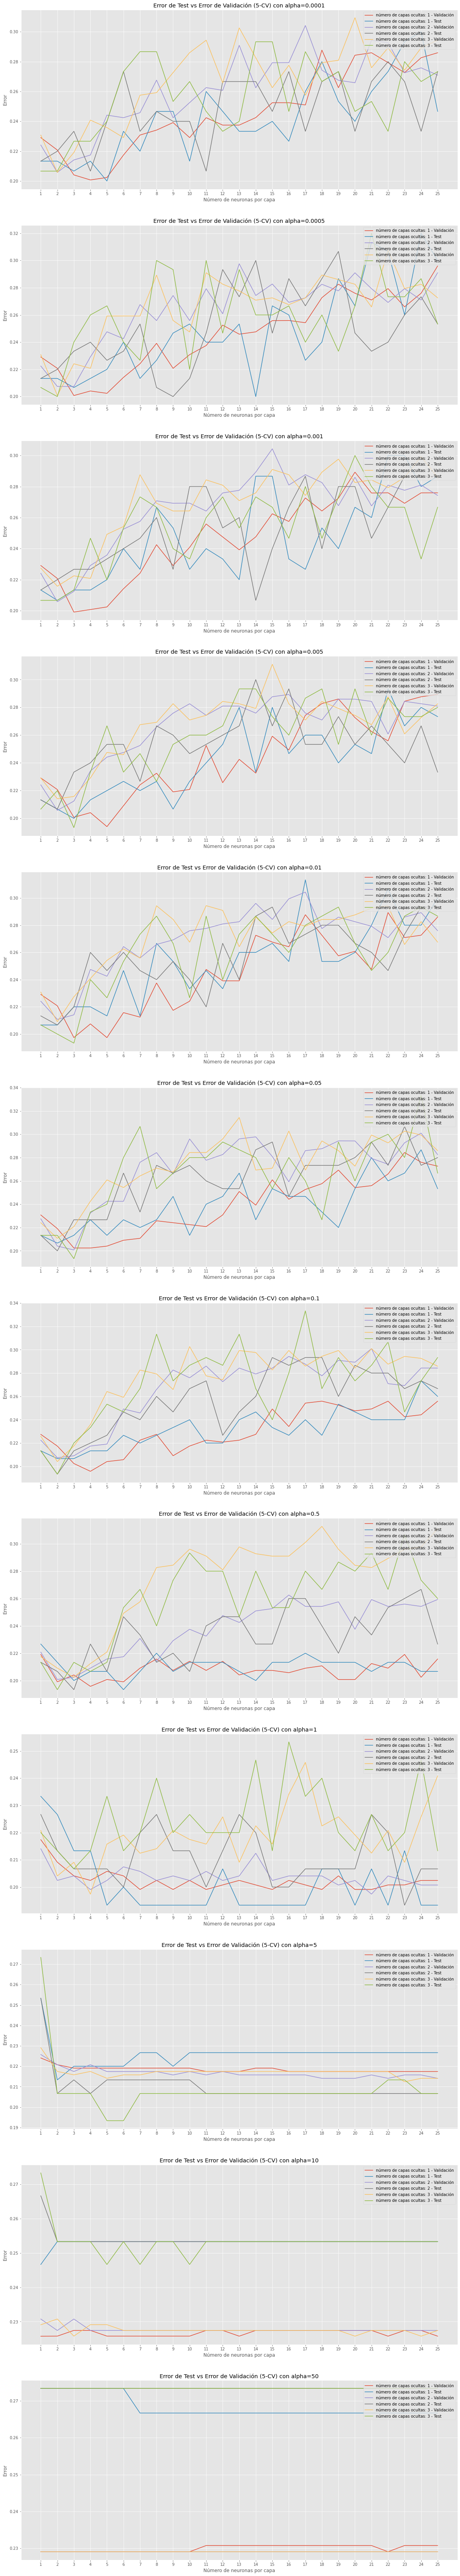

In [39]:
# Set up the graph
fig, axes = plt.subplots(figsize=(20, 120), nrows=len(hyperparameters['alpha']))

# Set the counter to graph on the correct axes
counter = 0

# Graph for every combination of number of layers and value of alpha
for alpha in hyperparameters['alpha']:
    cv_results_one_layer = cv_results[cv_results['n_hidden_layers'] == 1]
    cv_results_one_layer = cv_results_one_layer[cv_results_one_layer['param_alpha'] == alpha]
    cv_results_two_layer = cv_results[cv_results['n_hidden_layers'] == 2]
    cv_results_two_layer = cv_results_two_layer[cv_results_two_layer['param_alpha'] == alpha]
    cv_results_three_layer = cv_results[cv_results['n_hidden_layers'] == 3]
    cv_results_three_layer = cv_results_three_layer[cv_results_three_layer['param_alpha'] == alpha]

    test_results_one_layer = test_results[test_results['n_hidden_layers'] == 1]
    test_results_one_layer = test_results_one_layer[test_results_one_layer['param_alpha'] == alpha]
    test_results_two_layer = test_results[test_results['n_hidden_layers'] == 2]
    test_results_two_layer = test_results_two_layer[test_results_two_layer['param_alpha'] == alpha]
    test_results_three_layer = test_results[test_results['n_hidden_layers'] == 3]
    test_results_three_layer = test_results_three_layer[test_results_three_layer['param_alpha'] == alpha]

    # Graph
    axes[counter].set_title(f"Error de Test vs Error de Validación (5-CV) con alpha={alpha}")
    axes[counter].set_xlabel("Número de neuronas por capa")
    axes[counter].set_xticks(n_neurons_per_layer_array)
    axes[counter].set_ylabel("Error")
    axes[counter].errorbar(
        cv_results_one_layer['n_neurons_per_layer'],
        cv_results_one_layer['mean_test_score'],
        label=f'número de capas ocultas: {1} - Validación',
        capsize = 3)
    axes[counter].errorbar(
        test_results_one_layer['n_neurons_per_layer'],
        test_results_one_layer['mean_test_score'],
        label=f'número de capas ocultas: {1} - Test',
        capsize = 3)

    axes[counter].errorbar(
        cv_results_two_layer['n_neurons_per_layer'],
        cv_results_two_layer['mean_test_score'],
        label=f'número de capas ocultas: {2} - Validación',
        capsize = 3)
    axes[counter].errorbar(
        test_results_two_layer['n_neurons_per_layer'],
        test_results_two_layer['mean_test_score'],
        label=f'número de capas ocultas: {2} - Test',
        capsize = 3)

    axes[counter].errorbar(
        cv_results_three_layer['n_neurons_per_layer'],
        cv_results_three_layer['mean_test_score'],
        label=f'número de capas ocultas: {3} - Validación',
        capsize = 3)
    axes[counter].errorbar(
        test_results_three_layer['n_neurons_per_layer'],
        test_results_three_layer['mean_test_score'],
        label=f'número de capas ocultas: {3} - Test',
        capsize = 3)
    
    axes[counter].legend(loc="upper right")

    # Update counter
    counter += 1


Para los valores pequeños del hiper-parámetro `alpha`, menores que 0,5; más o menos el error de entrenamiento se ajusta al error de test, aunque ambos errores fluctúan bastante. Aún así, si que hay casos donde el error de entrenamiento apróxima bastante bien el error de test, como puede ser el caso del valor de `alpha` igual a 0,5. En este caso sí que se puede ver una relación bastante alta entre ambos errores.

El **menor error de test** se consigue para los siguientes valores de los hiper-parámetros:

In [44]:
test_results_best = test_results[test_results['rank_test_score'] == 1]
test_results_best.loc[:, [
    'param_hidden_layer_sizes', 
    'param_alpha',
    'n_hidden_layers',
    'n_neurons_per_layer',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='n_hidden_layers',
    ascending=True
).head(20)


param_hidden_layer_sizes param_alpha  n_hidden_layers  \
609                    (10,)           1                1   
614                    (15,)           1                1   
613                    (14,)           1                1   
612                    (13,)           1                1   
610                    (11,)           1                1   
619                    (20,)           1                1   
608                     (9,)           1                1   
607                     (8,)           1                1   
615                    (16,)           1                1   
606                     (7,)           1                1   
621                    (22,)           1                1   
530                     (6,)         0.5                1   
623                    (24,)           1                1   
624                    (25,)           1                1   
604                     (5,)           1                1   
616                    (17,)           1                1   
552                   (3, 3)         0.5                2   
476                   (2, 2)         0.1                2   
647                 (23, 23)           1                2   
277                (3, 3, 3)       0.005                3   

     n_neurons_per_layer  mean_test_score  std_test_score  rank_test_score  
609                   10         0.193333             0.0                1  
614                   15         0.193333             0.0                1  
613                   14         0.193333             0.0                1  
612                   13         0.193333             0.0                1  
610                   11         0.193333             0.0                1  
619                   20         0.193333             0.0                1  
608                    9         0.193333             0.0                1  
607                    8         0.193333             0.0                1  
615                   16         0.193333             0.0                1  
606                    7         0.193333             0.0                1  
621                   22         0.193333             0.0                1  
530                    6         0.193333             0.0                1  
623                   24         0.193333             0.0                1  
624                   25         0.193333             0.0                1  
604                    5         0.193333             0.0                1  
616                   17         0.193333             0.0                1  
552                    3         0.193333             0.0                1  
476                    2         0.193333             0.0                1  
647                   23         0.193333             0.0                1  
277                    3         0.193333             0.0                1

El error de test para el valor seleccionado por la validación cruzada es:

In [45]:
test_results_cv_error = float(test_results.loc[229, 'mean_test_score'])
test_results_cv_error
               

0.21999999999999997

## Ejercicio 3

Ahora trabajaremos con el conjunto de datos de [EnergyEfficiciency](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency).

### Apartado 0

Cargamos los datos:

In [47]:
df_energy_efficiency = pd.read_csv(
    'data/EnergyEfficiency.data',
    delimiter=',',
    skiprows=1,
    header=None,
    names=["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y"]
)


### Apartado a

**Una de las clases que implementa el Perceptrón multicapa (MLP) en problemas de clasificación en `scikit‐learn` es `sklearn.neural_network.MLPRegressor`. Revisa los parámetros y métodos que tiene.**

Se revisa la documentación de la clase `sklearn.neural_network.MLPRegressor.` para entender los parámetros que tiene, qué hace cada uno, y los métodos que tiene, y cuál es la función de cada uno.

### Apartado b

**Divide los datos en entrenamiento (80%) y test (20%).**

Dividimos los datos en entrenamiento (80%) y test (20%) mediante este comando:

In [49]:
df_energy_efficiency_train, df_energy_efficiency_test = train_test_split(
    df_energy_efficiency, 
    test_size=0.2, 
    random_state=SEED_VALUE
)


Número de instancias en el conjunto de entrenamiento:

In [50]:
df_energy_efficiency_train.shape

(614, 9)

Número de instancias en el conjunto de test:

In [51]:
df_energy_efficiency_test.shape

(154, 9)

### Apartado c

**Realiza la experimentación con *MLPRegressor* usando los valores por defecto de los parámetros, excepto para activation='tanh' y solver='lbfgs', y max_iter=2000.**

En primer lugar, debemos estandarizar tanto las variables predictoras como las variables dependientes, al tratarse de un problema de regresión:

In [58]:
scaler = StandardScaler()
scaler.fit(df_energy_efficiency_train)
df_energy_efficiency_train_scaled = scaler.transform(df_energy_efficiency_train)
df_energy_efficiency_test_scaled = scaler.transform(df_energy_efficiency_test)


Los valores con los que se ha estandarizado son:

In [59]:
print(f"mean [X1, X2, X3, X4, X5, X6, X7, X8, Y]: {scaler.mean_}")
print(f"std [X1, X2, X3, X4, X5, X6, X7, X8, Y]: {scaler.scale_}")


mean [X1, X2, X3, X4, X5, X6, X7, X8, Y]: [7.62768730e-01 6.73191368e+02 3.18140879e+02 1.77525244e+02
 5.19869707e+00 3.47394137e+00 2.31921824e-01 2.83876221e+00
 2.43248697e+01]
std [X1, X2, X3, X4, X5, X6, X7, X8, Y]: [ 0.1069224  88.80609907 43.96132191 45.46444155  1.74924784  1.11918644
  0.13240652  1.54257571  9.45320583]


Volvemos a pasarlo a formato DataFrame:

In [60]:
df_energy_efficiency_train_scaled = pd.DataFrame(
    df_energy_efficiency_train_scaled,
    columns = df_energy_efficiency_train.columns,
    index = df_energy_efficiency_train.index
)

df_energy_efficiency_test_scaled = pd.DataFrame(
    df_energy_efficiency_test_scaled,
    columns = df_energy_efficiency_test.columns,
    index = df_energy_efficiency_test.index
)


En primer lugar, dividimos en variables predictoras y dependientes:

In [61]:
df_energy_efficiency_train_X_scaled = df_energy_efficiency_train_scaled.loc[:, [
    'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].astype(float)
df_energy_efficiency_train_Y_scaled = df_energy_efficiency_train_scaled.loc[:, 'Y']

df_energy_efficiency_test_X_scaled = df_energy_efficiency_test_scaled.loc[:, [
    'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].astype(float)
df_energy_efficiency_test_Y_scaled = df_energy_efficiency_test_scaled.loc[:, 'Y']


Definimos los hiper-parámetros a usar:

In [62]:
n_hidden_layers_array = range(1, 4, 1)
n_neurons_per_layer_array = range(1, 26, 1)
alpha_exp_array = range(-4, 2, 1)

# Generamos diferentes valores para el hiper-parametro del numero de capas
hidden_layer_sizes = []
for n_hidden_layers in n_hidden_layers_array:
    for n_neurons_per_layer in n_neurons_per_layer_array:
        hidden_layer_sizes.append((n_neurons_per_layer, ) * n_hidden_layers)

# Generamos diferentes valores para el hiper-parámetro alpha
alpha = []
for value in alpha_exp_array:
    alpha.append(10 ** value)
    alpha.append((10 ** value) * 5)

hyperparameters = {'hidden_layer_sizes': hidden_layer_sizes, 'alpha': alpha}


Y ejecutamos el entrenamiento:

In [63]:
neural_network = MLPRegressor(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)
modelCV = GridSearchCV(neural_network,
                       hyperparameters,
                       cv=5,
                       scoring='neg_mean_squared_error',
                       return_train_score=True,
                       n_jobs=-1)

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV.fit(df_energy_efficiency_train_X_scaled, df_energy_efficiency_train_Y_scaled)


GridSearchCV(cv=5,
             estimator=MLPRegressor(activation='tanh', max_iter=2000,
                                    random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                   0.1, 0.5, 1, 5, 10, 50],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,),
                                                (11,), (12,), (13,), (14,),
                                                (15,), (16,), (17,), (18,),
                                                (19,), (20,), (21,), (22,),
                                                (23,), (24,), (25,), (1, 1),
                                                (2, 2), (3, 3), (4, 4), (5, 5), ...]},
             return_train_score=True, scoring='neg_mean_squared_error')

Observamos los resultados obtenidos:

In [65]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results['mean_test_score'] = -cv_results['mean_test_score'] * (scaler.scale_[8]**2)
cv_results['std_test_score'] = cv_results['std_test_score'] * (scaler.scale_[8]**2)

cv_results.loc[:, [
    'param_hidden_layer_sizes', 
    'param_alpha',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


param_hidden_layer_sizes param_alpha  mean_test_score  std_test_score  \
518             (19, 19, 19)         0.1         0.466700        0.056198   
445             (21, 21, 21)        0.05         0.515897        0.100745   
449             (25, 25, 25)        0.05         0.518911        0.175630   
410                 (11, 11)        0.05         0.522690        0.098390   
443             (19, 19, 19)        0.05         0.533892        0.157021   
..                       ...         ...              ...             ...   
851                   (2, 2)          50        14.301187        1.525611   
877                (3, 3, 3)          50        14.644145        1.690561   
876                (2, 2, 2)          50        15.598289        1.852569   
850                   (1, 1)          50        16.939406        2.063837   
875                (1, 1, 1)          50        89.590964        6.354939   

     rank_test_score  
518                1  
445                2  
449                3  
410                4  
443                5  
..               ...  
851              896  
877              897  
876              898  
850              899  
875              900  

[900 rows x 5 columns]

**Muestra las gráficas del error de entrenamiento con validación cruzada (5‐CV) frente al valor de los hiper‐parámetros, y justifica la elección de los valores más apropiados. Para cada combinación de valor del número de capas ocultas y parámetro de regularización se debe generar una gráfica donde se represente en el eje horizontal el número de neuronas en la capa oculta.**

Para esto lo primero será procesar el DataFrame con los resultados de haber ejecutado la búsqueda de los mejores hiper-parámetros para obtener **el número de capas ocultas** y el **número de neuronas por capa** para cada una de las filas de este DataFrame a partir de la columna `param_hidden_layer_sizes`:

In [66]:
# Get number of layers for every row in the results DataFrame
hidden_layer_sizes = []
for tuple in cv_results['param_hidden_layer_sizes']:
    hidden_layer_sizes.append(len(tuple))
cv_results['n_hidden_layers'] = pd.Series(hidden_layer_sizes)

# Get number of neurons per layer for every row in the results DataFrame
neurons_per_layer = []
for tuple in cv_results['param_hidden_layer_sizes']:
    neurons_per_layer.append(tuple[0])
cv_results['n_neurons_per_layer'] = pd.Series(neurons_per_layer)


Mostramos las gráficas con los resultados del entrenamiento:

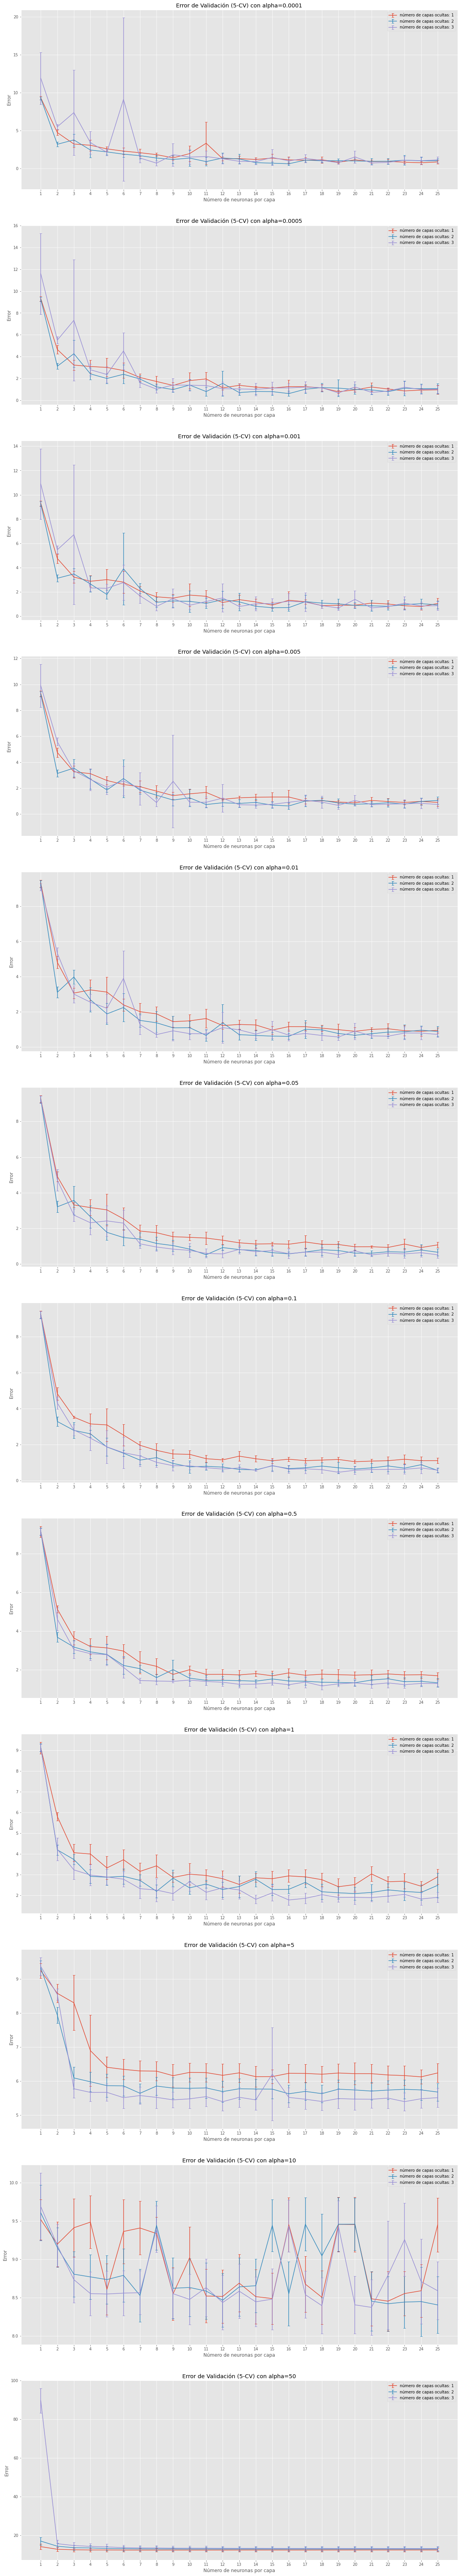

In [67]:
# Set up the graph
fig, axes = plt.subplots(figsize=(20, 120), nrows=len(hyperparameters['alpha']))

# Set the counter to graph on the correct axes
counter = 0

# Graph for every combination of number of layers and value of alpha
for alpha in hyperparameters['alpha']:
    cv_results_one_layer = cv_results[cv_results['n_hidden_layers'] == 1]
    cv_results_one_layer = cv_results_one_layer[cv_results_one_layer['param_alpha'] == alpha]

    cv_results_two_layer = cv_results[cv_results['n_hidden_layers'] == 2]
    cv_results_two_layer = cv_results_two_layer[cv_results_two_layer['param_alpha'] == alpha]

    cv_results_three_layer = cv_results[cv_results['n_hidden_layers'] == 3]
    cv_results_three_layer = cv_results_three_layer[cv_results_three_layer['param_alpha'] == alpha]

    # Graph
    axes[counter].set_title(f"Error de Validación (5-CV) con alpha={alpha}")
    axes[counter].set_xlabel("Número de neuronas por capa")
    axes[counter].set_xticks(n_neurons_per_layer_array)
    axes[counter].set_ylabel("Error")
    axes[counter].errorbar(
        cv_results_one_layer['n_neurons_per_layer'],
        cv_results_one_layer['mean_test_score'],
        cv_results_one_layer['std_test_score'],
        label=f'número de capas ocultas: {1}',
        capsize = 3)
    axes[counter].errorbar(
        cv_results_two_layer['n_neurons_per_layer'],
        cv_results_two_layer['mean_test_score'],
        cv_results_two_layer['std_test_score'],
        label=f'número de capas ocultas: {2}',
        capsize = 3)
    axes[counter].errorbar(
        cv_results_three_layer['n_neurons_per_layer'],
        cv_results_three_layer['mean_test_score'],
        cv_results_three_layer['std_test_score'],
        label=f'número de capas ocultas: {3}',
        capsize = 3)
    axes[counter].legend(loc="upper right")

    # Update counter
    counter += 1


En primer lugar, al igual que antes, para los valores garndes del hiper-parámetro `alpha` (valores mayores que 1), la red no está aprendiendo correctamente.

Para los valores menores de `alpha`, la red mejora el error de entrenamiento hasta las 10 neuronas por cada una de las capas ocultas, en este momento el error se estanca y no sigue mejorando a medida que se van aumentando el número de capas. Teniendo esto en cuenta, junto con que el tiempo de entrenamiento crece rápidamente a medida que crece el número de neuronas por capa, los mejores valores de los hiper-parámetros serán los que nos proporcionen un mejor error de entrenamiento para los hiper-parámetros que hemos porbado.

El **menor error de validación cruzada**, **su desviación estándar** y el **hiper-parámetro para el que se consigue** es el siguiente:

In [68]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]

cv_results_best.loc[:, [
    'param_hidden_layer_sizes', 
    'param_alpha',
    'n_hidden_layers',
    'n_neurons_per_layer',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='n_hidden_layers', 
    ascending=False
).head()


param_hidden_layer_sizes param_alpha  n_hidden_layers  \
518             (19, 19, 19)         0.1                3   

     n_neurons_per_layer  mean_test_score  std_test_score  rank_test_score  
518                   19           0.4667        0.056198                1

**Muestra la gráfica del error de test frente al valor de los hiper‐parámetros (siguiendo el mismo esquema que en el apartado anterior), y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test.**

En primer lugar, debemos calcular el error de test frente a los valores de los hiper-parámetros:

In [69]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_energy_efficiency_train_Y_scaled) + [0] * len(df_energy_efficiency_test_Y_scaled)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_energy_efficiency_all_X_scaled = np.vstack([df_energy_efficiency_train_X_scaled, df_energy_efficiency_test_X_scaled])
df_energy_efficiency_all_Y_scaled = np.hstack([df_energy_efficiency_train_Y_scaled, df_energy_efficiency_test_Y_scaled])

neural_network = MLPRegressor(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)
modelCV = GridSearchCV(neural_network,
                       hyperparameters,
                       cv=ps,
                       scoring='neg_mean_squared_error',
                       return_train_score=True,
                       n_jobs=-1)

# Semilla:
np.random.seed(SEED_VALUE)
modelCV.fit(df_energy_efficiency_all_X_scaled, df_energy_efficiency_all_Y_scaled)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPRegressor(activation='tanh', max_iter=2000,
                                    random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                   0.1, 0.5, 1, 5, 10, 50],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,),
                                                (11,), (12,), (13,), (14,),
                                                (15,), (16,), (17,), (18,),
                                                (19,), (20,), (21,), (22,),
                                                (23,), (24,), (25,), (1, 1),
                                                (2, 2), (3, 3), (4, 4), (5, 5), ...]},
             return_train_score=True, scoring='neg_mean_squared_error')

Mostramos el resultado por pantalla:

In [70]:
test_results = pd.DataFrame(modelCV.cv_results_)
test_results['mean_test_score'] = -test_results['mean_test_score'] * (scaler.scale_[8]**2)
test_results['std_test_score'] = test_results['std_test_score'] * (scaler.scale_[8]**2)

test_results.loc[:, [
    'param_hidden_layer_sizes', 
    'param_alpha',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by="rank_test_score"
)


param_hidden_layer_sizes param_alpha  mean_test_score  std_test_score  \
262                 (13, 13)       0.005         0.396788             0.0   
210             (11, 11, 11)       0.001         0.406693             0.0   
363             (14, 14, 14)        0.01         0.410665             0.0   
439             (15, 15, 15)        0.05         0.422742             0.0   
188                 (14, 14)       0.001         0.423733             0.0   
..                       ...         ...              ...             ...   
851                   (2, 2)          50        16.944902             0.0   
877                (3, 3, 3)          50        17.240206             0.0   
876                (2, 2, 2)          50        17.721611             0.0   
850                   (1, 1)          50        18.807058             0.0   
875                (1, 1, 1)          50        94.804661             0.0   

     rank_test_score  
262                1  
210                2  
363                3  
439                4  
188                5  
..               ...  
851              896  
877              897  
876              898  
850              899  
875              900  

[900 rows x 5 columns]

Igual que antes, es necesario procesar el DataFrame con los resultados para después poder mostrar las gráficas:

In [71]:
# Get number of layers for every row in the results DataFrame
hidden_layer_sizes = []
for tuple in test_results['param_hidden_layer_sizes']:
    hidden_layer_sizes.append(len(tuple))
test_results['n_hidden_layers'] = pd.Series(hidden_layer_sizes)

# Get number of neurons per layer for every row in the results DataFrame
neurons_per_layer = []
for tuple in test_results['param_hidden_layer_sizes']:
    neurons_per_layer.append(tuple[0])
test_results['n_neurons_per_layer'] = pd.Series(neurons_per_layer)


Ahora procedemos a mostrar las gráficas de error de test frente a los valores de los hiper-parámetros junto con la gráfica con el error de entrenamiento con validación cruzada para ver si este último hizo una buena estimación del error de test. Al igual que antes agruparemos las gráficas para mostrar, para cada uno de los valores de `alpha` el error de entrenamiento y el de validación de test, para los tres valores para el número de cpas ocultas, con el número de neuronas por capa en el eje horizontal:

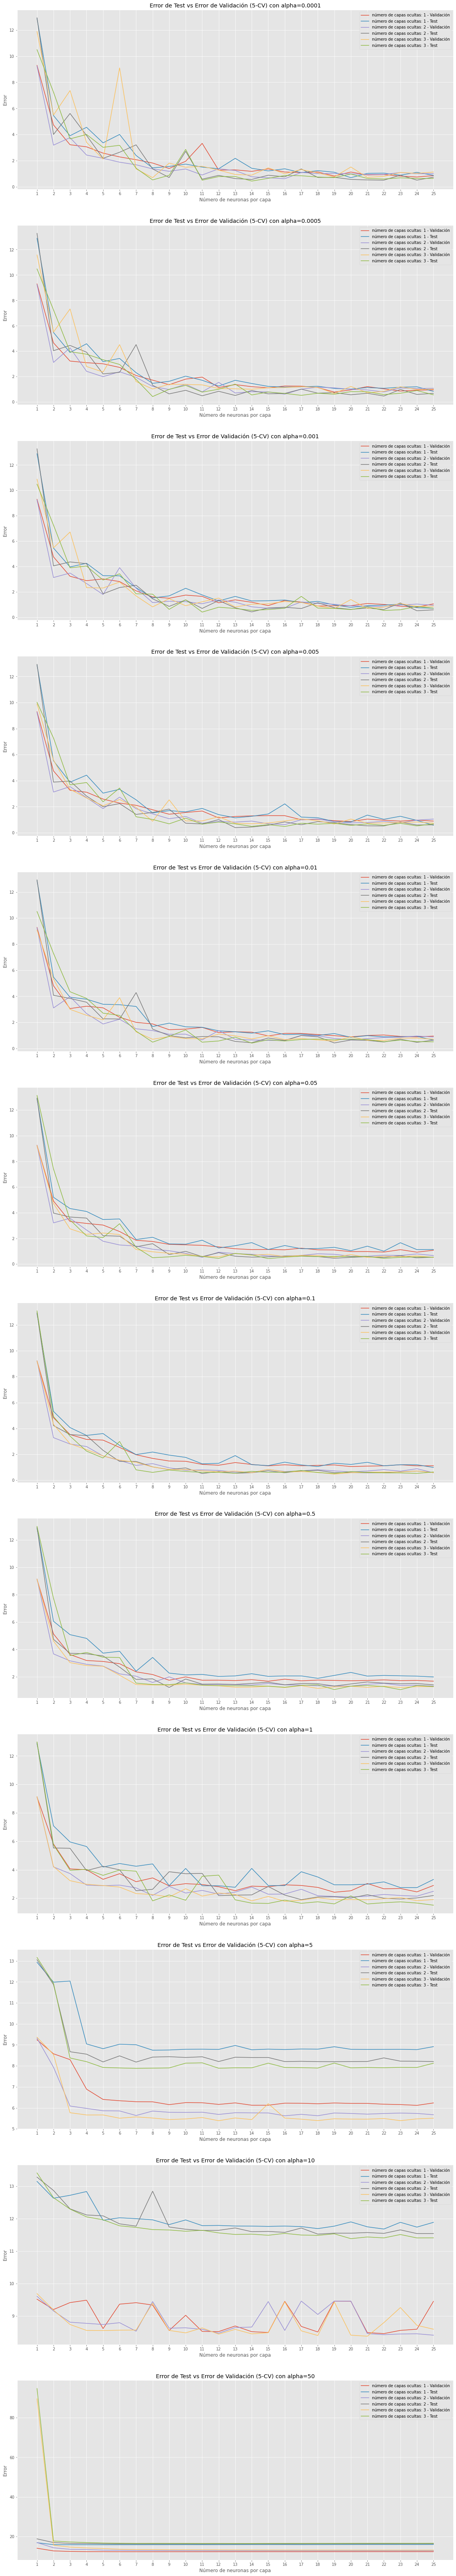

In [72]:
# Set up the graph
fig, axes = plt.subplots(figsize=(20, 120), nrows=len(hyperparameters['alpha']))

# Set the counter to graph on the correct axes
counter = 0

# Graph for every combination of number of layers and value of alpha
for alpha in hyperparameters['alpha']:
    cv_results_one_layer = cv_results[cv_results['n_hidden_layers'] == 1]
    cv_results_one_layer = cv_results_one_layer[cv_results_one_layer['param_alpha'] == alpha]
    cv_results_two_layer = cv_results[cv_results['n_hidden_layers'] == 2]
    cv_results_two_layer = cv_results_two_layer[cv_results_two_layer['param_alpha'] == alpha]
    cv_results_three_layer = cv_results[cv_results['n_hidden_layers'] == 3]
    cv_results_three_layer = cv_results_three_layer[cv_results_three_layer['param_alpha'] == alpha]

    test_results_one_layer = test_results[test_results['n_hidden_layers'] == 1]
    test_results_one_layer = test_results_one_layer[test_results_one_layer['param_alpha'] == alpha]
    test_results_two_layer = test_results[test_results['n_hidden_layers'] == 2]
    test_results_two_layer = test_results_two_layer[test_results_two_layer['param_alpha'] == alpha]
    test_results_three_layer = test_results[test_results['n_hidden_layers'] == 3]
    test_results_three_layer = test_results_three_layer[test_results_three_layer['param_alpha'] == alpha]

    # Graph
    axes[counter].set_title(f"Error de Test vs Error de Validación (5-CV) con alpha={alpha}")
    axes[counter].set_xlabel("Número de neuronas por capa")
    axes[counter].set_xticks(n_neurons_per_layer_array)
    axes[counter].set_ylabel("Error")
    axes[counter].errorbar(
        cv_results_one_layer['n_neurons_per_layer'],
        cv_results_one_layer['mean_test_score'],
        label=f'número de capas ocultas: {1} - Validación',
        capsize = 3)
    axes[counter].errorbar(
        test_results_one_layer['n_neurons_per_layer'],
        test_results_one_layer['mean_test_score'],
        label=f'número de capas ocultas: {1} - Test',
        capsize = 3)

    axes[counter].errorbar(
        cv_results_two_layer['n_neurons_per_layer'],
        cv_results_two_layer['mean_test_score'],
        label=f'número de capas ocultas: {2} - Validación',
        capsize = 3)
    axes[counter].errorbar(
        test_results_two_layer['n_neurons_per_layer'],
        test_results_two_layer['mean_test_score'],
        label=f'número de capas ocultas: {2} - Test',
        capsize = 3)

    axes[counter].errorbar(
        cv_results_three_layer['n_neurons_per_layer'],
        cv_results_three_layer['mean_test_score'],
        label=f'número de capas ocultas: {3} - Validación',
        capsize = 3)
    axes[counter].errorbar(
        test_results_three_layer['n_neurons_per_layer'],
        test_results_three_layer['mean_test_score'],
        label=f'número de capas ocultas: {3} - Test',
        capsize = 3)
    
    axes[counter].legend(loc="upper right")

    # Update counter
    counter += 1


En este caso, para los valores de `alpha` por debajo de 1, el error de entrenamiento predice de forma bastante precisa el error de test.

El **menor error de test** se consigue para los siguientes valores de los hiper-parámetros:

In [73]:
test_results_best = test_results[test_results['rank_test_score'] == 1]
test_results_best.loc[:, [
    'param_hidden_layer_sizes', 
    'param_alpha',
    'n_hidden_layers',
    'n_neurons_per_layer',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='n_hidden_layers',
    ascending=False
).head()


param_hidden_layer_sizes param_alpha  n_hidden_layers  \
262                 (13, 13)       0.005                2   

     n_neurons_per_layer  mean_test_score  std_test_score  rank_test_score  
262                   13         0.396788             0.0                1

El error de test para el valor seleccionado por la validación cruzada es:

In [74]:
test_results_cv_error = float(test_results.loc[518, 'mean_test_score'])
test_results_cv_error


0.515357834076244